In [1]:
import sys
import numpy as np
import scipy

import matplotlib.pyplot as plt

#sys.path.append('//home/crombez/Documents/PhD/python/openspyrit/spyrit/spyrit/learning/') 
from spyrit.misc.statistics import stat_mean_coef_from_model
from spyrit.misc.metrics import *
from spyrit.learning.nets import *
from spyrit.learning.model_Had_1D_DCAN import compNet_1D, Pinv_reg, compNet_1D_test_product, compNet_1D_size_im, compNet_1D_size_im_f,compNet_1D_size_stat,compNet_1D_size_stat_norma

sys.path.append('/home/crombez/Documents/PhD/python/MOPDC/fonction/') 
from data_visualisation import *
from load_data import *
from matrix_tools import *
from walsh_hadamard import *
from walsh_ordered_recon import *

In [2]:
%matplotlib 
#inline 

Using matplotlib backend: Qt5Agg


In [3]:
path_data = "/home/crombez/Documents/PhD/python/MOPDC/Data_save/Preposs_data/"
name_data = "clean20_raw_egfp_dsded2_432x128x128.npy"
Nl = 432
Nc = 512
Nd = 512
N_lambda = 128
M = 128
hyper_cube = np.load(path_data+name_data)

In [8]:
Face = hyper_cube[0]
#Face = np.where(Face<500,Face,0)

plot_im2D(Face,cmap='gray')

### Neural Networks parameters

In [8]:
bs = 512#128
data_root = '/home/crombez/Documents/PhD/python/openspyrit/Train_and_Test/Had_1D_DCAN/data/'
alpha = 1e-1
variant = 2

Net_name = "NETttref_imstat_comp_tranpose_N_432x512_M_128_epo_1_lr_0.001_sss_20_sdr_0.2_bs_64_reg_1e-07"
Net_root = '/home/crombez/Documents/PhD/python/openspyrit/Train_and_Test/Had_1D_DCAN/models/Train_from_JZ/'#'model_stl10/'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Acquisition matrix

In [5]:
W = walsh_ordered(512)
H_exp = W
plot_im2D(W)

### Statitic of the acquisition matrix 

In [6]:
root = '/home/crombez/Documents/PhD/python/MOPDC/Data_save/Stat_network/'
model = 'th'
if model == "th":
    Mean_file = "Wth_Average_Nx{}_Nh{}.npy".format(Nc,Nc)
    Cov_file = "Wth_Cov_Nx{}_Nh{}.npy".format(Nc,Nc)
else :
    Mean_file = "Wexp_Average_Nx{}_Nh{}.npy".format(Nc,Nc)
    Cov_file = "Wexp_Cov_Nx{}_Nh{}.npy".format(Nc,Nc)
Mean = np.load(root+Mean_file)
Cov = np.load(root+Cov_file)

### load neural network

In [9]:
mdt =np.ones((Nl,Nc))
mdt = torch.from_numpy(H_exp)
mdt = mdt.float()
mdt = mdt.to(device)


model = compNet_1D_size_stat(Nl, Nc, Nd, M, mdt, Cov, Mean, RC=2, Stat_comp=True, alpha=1)#compNet_1D_size_stat_norma(Nl,Nc,Nh,M, mdt,Cov,Mean, RC=1,Stat_comp=True,alpha = 1e-1)#compNet_1D_size_stat(Nl,Nc,Nh,M, mdt,Cov,Mean, RC=1,Stat_comp=True,alpha = 1e-1)#compNet_1D_size_im_f( Nl,Nc,Nh,M, mdt, variant,alpha)#
model = model.float()

load_net(Net_root+Net_name, model,device)


if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

model = model.to(device)

Statistic completion
Measurement to image domain: Transpose
Model Loaded: /home/crombez/Documents/PhD/python/openspyrit/Train_and_Test/Had_1D_DCAN/models/Train_from_JZ/NETttref_imstat_comp_tranpose_N_432x512_M_128_epo_1_lr_0.001_sss_20_sdr_0.2_bs_64_reg_1e-07


## Direct Reconstruction

In [ ]:
rc_hyper = np.zeros((Nl,Nc,N_lambda))
for i in range(N_lambda):
    rc_hyper[:,:,i] = np.dot(hyper_cube[:,:,i],W[:M])/Nc

In [10]:
data = hyper_cube
rc_hyper = np.zeros((432,512,128))
for i in range(128):
    raw_data = data[:,:,i]
    (b,c,h,w) = (1,1,Nl,Nc)
    m =np.ones((1,1,Nl,M))

    m[0][0] = raw_data[:,:M]
    m = torch.from_numpy(m)
    m = m.float()
    m = m.to(device)

    res = model.forward_reconstruct(m,b,c,h,w).cpu().detach().numpy()
    rc_hyper[:,:,i] = res[0][0]

In [11]:
Save_path = "/home/crombez/Documents/PhD/python/MOPDC/Data_save/Recon_data/"
file_name = "rc_clean20_egfp_dsded2_432x512x128.npy"
np.save(Save_path+file_name,rc_hyper)

In [ ]:
stack = np.zeros((Nl,Nc))
for i in range(128):
    stack += rc_hyper[:,:,i]
plot_im2D(stack,cmap='gray')

In [ ]:
save_stack = stack

In [ ]:
plot_im2D(np.abs(stack-save_stack))

In [ ]:
plot_im2D(save_stack,cmap='gray')

In [ ]:
stack = np.zeros((Nl,M))
for i in range(128):
    stack += hyper_cube[:,:,i]

rc = np.dot(stack,W[:M])/Nc
Min = np.min(rc)
Max = np.max(rc)

print(Min,Max)
(b,c,h,w) = (1,1,Nl,Nc)
m =np.ones((1,1,Nl,M))
m[0][0] = stack[:,:M]
m = torch.from_numpy(m)
m = m.float()
m = m.to(device)
raw =  torch.matmul(m,mdt[:M])/Nc
raw = 2*(raw-Min)/(Max-Mmin)-1
m=  torch.matmul(raw,mdt[:,:M])
#m =  torch.matmul(raw,mdt[:M])/Nh
    

#m = m/m.max()
res = model.forward_maptoimage(m,b,c,h,w)
#res = res/res.max()
#res = res*2/res.max()-1
#res = torch.where(res<0.4,res,torch.tensor(0.4))
#res -= 1
res2 = model.forward_postprocess(res,b,c,h,w)
res = res.cpu()
res2 = res2.cpu()
numpy_array= res.detach().numpy()[0][0]
numpy_array2= res2.detach().numpy()[0][0]

#raw = model.forward_acquire(m,b,c,h,w)
raw  = torch.matmul(m,mdt[:M])/Nc
raw = raw.cpu().detach().numpy()[0][0]



res = model.forward_maptoimage(m,b,c,h,w)
res2 = model.forward_postprocess(res,b,c,h,w)
raw  = torch.matmul(m,mdt[:M])/Nc
 
res = res.cpu().detach().numpy()[0][0]
res2 = res2.cpu().detach().numpy()[0][0]
raw = raw.cpu().detach().numpy()[0][0]

rc_phi = un_center_norma(res,Min,Max)#res#
rc_phi_learn = un_center_norma(res2,Min,Max)#res2#
rc_direct = un_center_norma(raw,Min,Max)#raw#

In [ ]:
plot_im2D(rc_phi,cmap='gray',title='phi')
plot_im2D(rc_phi_learn,cmap='gray',title='phi + learn')
plot_im2D(rc_direct,title='direct',cmap='gray')
#plot_im2D(image[180:260,305:460] ,cmap='gray',title='gt')

In [ ]:
def center_norma(Mat):
    M_max = np.max(Mat)
    M_min = np.min(Mat)
    M_out = Mat-M_min
    M_out = 2*M_out/(M_max-M_min)
    M_out = M_out-1
    return(M_out,M_min,M_max)
    
def un_center_norma(Mat,M_min,M_max):
    M_out = Mat+1
    M_out = M_out*(M_max-M_min)/2
    M_out = M_out + M_min
    return(M_out)

In [ ]:
a = -2

a-a

In [ ]:
mat,Mmin,Mmax = center_norma(stack)
mat = un_center_norma(mat,Mmin,Mmax)
plot_im2D(mat,cmap='gray')

***** Name file : fish_avant_meusre512.fits *****
Type de données : Counts
Mode d'acquisition : Single Scan
Temps d'exposition : 5.000004
Temps de lecture : 1.785714e-09
Longeur d'onde de Rayleigh : 422.0
Longeur d'onde détectée : 550.0
***********************************



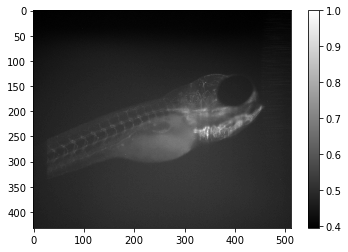

In [3]:
from astropy.io import fits
path = '/run/media/crombez/Elements/HSPIM_seb_acquisition/Manip_2eme_annee/manip_07_07_2021/'#'/run/media/crombez/Elements/HSPIM_seb_acquisition/Manip_2eme_annee/manip_15_03_21/SPIM_view/'# 
file = 'fish_avant_meusre512.fits'#'fish_avant_meusre.fits'#'Poisson_2_DsRed2_apres_chspim.fits'#

hdul = fits.open(path+file)
show_images_infos(path,file)

image =np.array(hdul[0].data[0])
image = np.flipud(image)
image = bining_colonne(image,5)
image = bining_line(image,5)
image = image/np.max(image)

plot_im2D(image,cmap='gray')

In [4]:
W = walsh_ordered(512)
Wp = np.where(W > 0, W, 0)
Wn = np.where(W < 0, np.abs(W), 0)

In [ ]:
PEAK = 10000
noisy = image+np.random.poisson(image / 255.0 * PEAK) / PEAK * 255
plot_im2D(noisy)

In [ ]:
plot_im2D(image-noisy)

In [ ]:
image_coeff = np.dot(image,W)
n = 512
image_rc_sech = np.dot(image_coeff[:,:n],W[:n])
plot_im2D(image_rc_sech)

In [ ]:
coeff_p = np.dot(image,Wp)
coeff_n = np.dot(image,Wn)
image_coeff = coeff_p-coeff_n
image_coeff_noi = (np.sqrt(coeff_p)*noise_mask/np.max(noise_mask)/5)-(coeff_n+np.random.poisson(coeff_n / 255.0 * PEAK) / PEAK * 255)
plot_im2D(np.dot(image_coeff,W)/512)
#image_coeff_noi = image_coeff+np.random.poisson(image_coeff / 255.0 * PEAK) / PEAK * 255
#plot_im2D(image_coeff_noi)

In [ ]:
plot_im2D(coeff_n)

In [ ]:
plot_im2D(coeff_p)

In [ ]:
plot_im2D(image_coeff)

In [ ]:
plot_im2D(image_coeff_noi)

In [23]:
noise_mask = np.random.poisson(image)

noisy = image + noise_mask/np.max(noise_mask)/5
plot_im2D(noisy)